# Bølgefysikk og fluidmekanikk numerisk prosjekt

In [1]:
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

### Constants

In [2]:
L = 1.0 # [m]
g = 9.8 # [m/s^2]
theta_0 = 0.2 # [rad]
omega_0 = 0 # [rad/s]
q = 1.0 # [1/s]
w_0 = np.sqrt(g/L) # [1/s]
FD = 0.2 # [N]

### Solvers

In [3]:
def RHS(theta: float, omega: float, t: float, wD: float) -> tuple[float, float]:
    """
    Returns right-hand-side of eq.
    Returns d_theta, d_omega
    """
    return omega, -g/L * theta - q*omega + FD * np.sin(wD*t)

In [4]:
def RK4_step(
        RHS: Callable[[float, float, float, float], tuple[float, float]],
        theta: float,
        omega: float,
        dt: float,
        t: float,
        wD: float
) -> tuple[float, float]:
    """
    Calculates one step of the RK4-algorithm.
    
    theta: float
    previous value of theta
           
    w: float
    previous value of w (omega, angular velocity)
    
    dt: float
    timestep
    
    return: theta, omega
    """
    # k = omega
    # f = theta
    f1, k1 = RHS(theta, omega, t, wD)
    f2, k2 = RHS(theta + (dt/2)*f1, omega + (dt/2)*k1, t, wD)
    f3, k3 = RHS(theta + (dt/2)*f2, omega + (dt/2)*k2, t, wD)
    f4, k4 = RHS(theta + dt*f3, omega + dt*k3, t, wD)
    return theta + (dt/6)*(f1 + (2*f2) + (2*f3) + f4), omega + (dt/6)*(k1 + (2*k2) + (2*k3) + k4)

def RK4_solver(
        RHS: Callable[[float, float, float, float], tuple[float, float]],
        T: float,
        dt: float,
        theta_0: float,
        omega_0: float,
        wD: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Computes theta and w (omega).  
    
    Parameters
    -----------
    RHS: RHS of equation
    theta0: initial value of theta
    w0: initail value of omega
    dt: timestep
    T: time
    wD: wD
    
    return theta, omega, t
    """
    t_array = np.arange(0, T+dt, dt)
    # T_array = np.linspace(0, T, int(T/dt))
    theta_array = np.zeros_like(t_array)
    omega_array = np.zeros_like(t_array)
    theta_array[0] = theta_0
    omega_array[0] = omega_0
    for i in range(1, len(t_array)):
        theta, omega = RK4_step(RHS, theta_array[i-1], omega_array[i-1], dt, t_array[i-1], wD)
        theta_array[i] = theta
        omega_array[i] = omega
    return theta_array, omega_array, t_array

In [5]:
def Euler_Cromer_solver(
    RHS: Callable[[float, float, float, float], tuple[float, float]],
    T: float,
    dt: float,
    theta_0: float,
    omega_0: float,
    wD: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Euler-Cromer-solver

    Args:
        d_omega_equation (Callable[[float, float, float], float]): _description_
        T (float): _description_
        dt (float): _description_
        theta_0 (float): _description_
        omega_0 (float): _description_

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: _description_
    """
    t_array = np.arange(0, T+dt, dt)
    theta_array = np.zeros_like(t_array)
    omega_array = np.zeros_like(t_array)

    theta_array[0] = theta_0
    omega_array[0] = omega_0
    
    for i in range(1, len(t_array)):
        omega_array[i] = omega_array[i-1] + RHS(theta_array[i-1], omega_array[i-1], t_array[i-1],wD)[1]*dt
        theta_array[i] = theta_array[i-1] + omega_array[i]*dt
    
    return theta_array, omega_array, t_array
    


In [6]:
def calculate_energy(theta, omega):
    E_k = 1/2*L**2*omega**2
    E_p = 1/2*g*L*theta**2
    return E_k + E_p

### Plotting

In [7]:
def plot_data(
    x_arrays: list[np.ndarray],
    y_arrays: list[np.ndarray],
    legends: list[str],
    xlabel: str,
    ylabel: str,
    title: str,
    show: bool = False
) -> None:
    """Plot x_values to corresponding y_values 

    Args:
        x_arrays (list[np.ndarray]): _description_
        y_arrays (list[np.ndarray]): _description_
        legends (list[str]): _description_
        xlabel (str): _description_
        ylabel (str): _description_
        title (str): _description_
    """
    for x_arr, y_arr, legend in zip(x_arrays, y_arrays, legends):
        plt.plot(x_arr, y_arr, label=legend)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    save_path = Path(__name__).parent / "Plots" / f"{title}.png"
    plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

## Oppg. 1

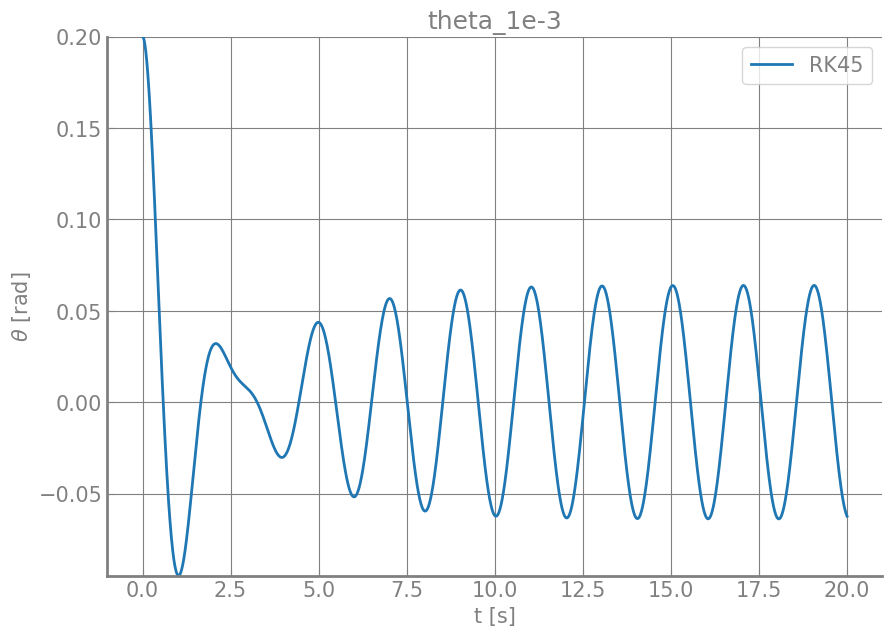

In [15]:
T = 20 # [s]
dt = 1e-2 # [s]
wD = 3.13

theta_vals, omega_vals, t_array = RK4_solver(
    RHS=RHS,
    T=T,
    dt=dt,
    theta_0=theta_0,
    omega_0=omega_0,
    wD=wD
)
plot_data(
    x_arrays=[t_array],
    y_arrays=[theta_vals],
    legends=["RK45"],
    xlabel="t [s]",
    ylabel=r"$\theta$ [rad]",
    title="theta_1e-3",
    show=True
)


## Oppg. 2

In [9]:
def get_energy_difference(
        solver: Callable,
        dt: float,
        wD: float,
        T: float,
        T_begin_slice: float
):
    theta_array, omega_array, t_arr = solver(RHS, T, dt, theta_0, omega_0, wD)
    energy_array = calculate_energy(theta_array, omega_array)
    end_slice = t_arr > T_begin_slice
    E_diff_reference = np.abs(np.max(energy_array[end_slice]) - energy_array[0])
    return E_diff_reference

In [10]:
def convergence_test(
        solver: Callable,
        dt_range: tuple[float, float],
        dt_increment: float,
        wD: float,
        T: float,
        T_begin_slice: float
) -> tuple[np.ndarray, np.ndarray]:
    dt_array = np.arange(dt_range[0], dt_range[1]+dt_increment, dt_increment)
    energy_difference_array = np.zeros_like(dt_array)
    E_diff_reference = get_energy_difference(solver, dt_range[0], wD, T, T_begin_slice)

    for i, dt in enumerate(dt_array):
        E_diff = get_energy_difference(solver, dt, wD, T, T_begin_slice)
        E_rel_diff = np.abs(E_diff - E_diff_reference)
        energy_difference_array[i] = E_rel_diff
    
    return energy_difference_array, dt_array

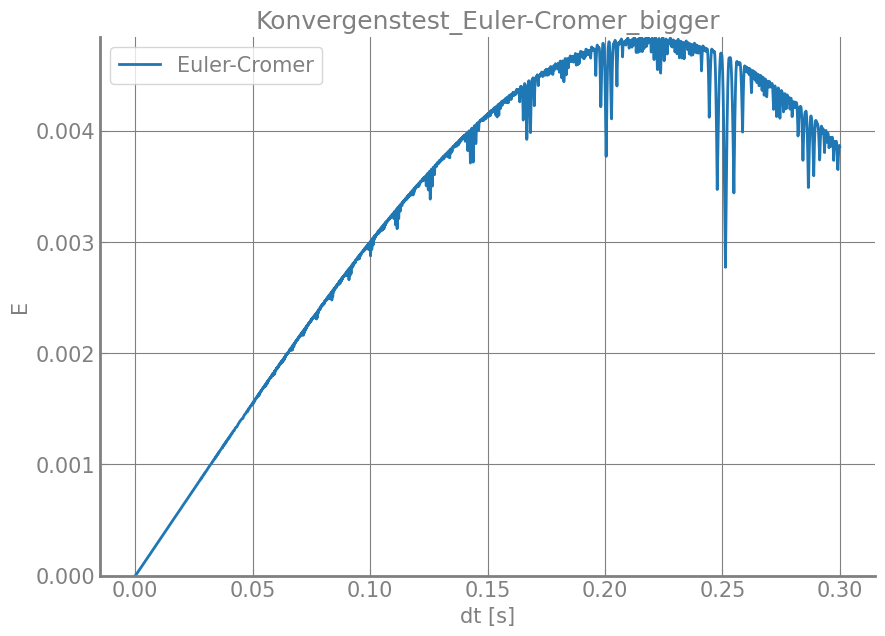

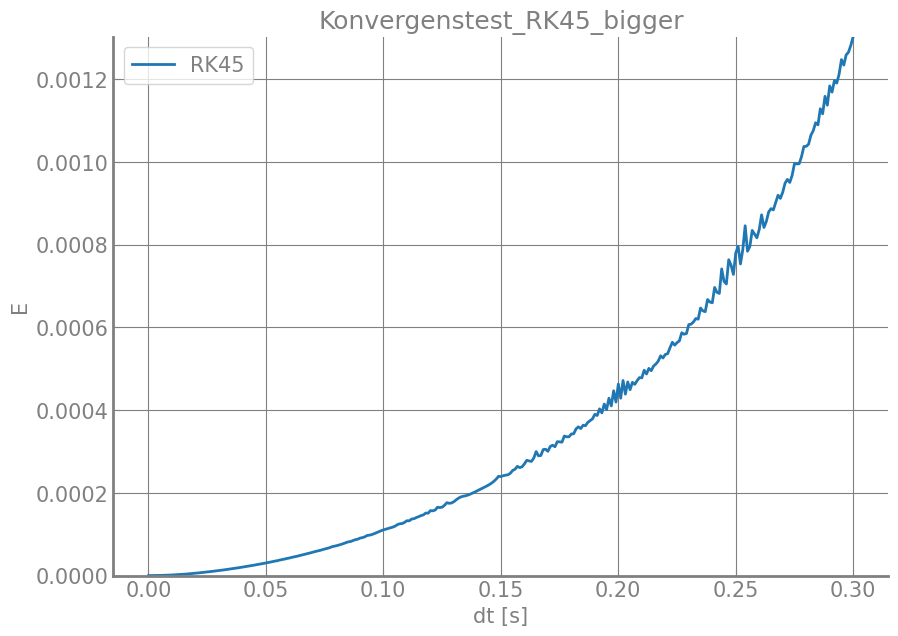

In [16]:
wD = 3.13 # [1/s]

dt_range = (1e-5, 0.3)
dt_increment = 1e-4
T_begin_slice = 15
T = 20

energy, dt_arr = convergence_test(Euler_Cromer_solver, dt_range, dt_increment, wD, T, T_begin_slice)
plot_data(
    x_arrays=[dt_arr],
    y_arrays=[energy],
    legends=["Euler-Cromer"],
    xlabel="dt [s]",
    ylabel="E",
    title="Konvergenstest_Euler-Cromer_bigger",
    show=True
)

dt_range = (1e-4, 0.3)
dt_increment = 1e-3

energy_difference_array, dt_array = convergence_test(RK4_solver, dt_range, dt_increment, wD, T, T_begin_slice)
plot_data(
    x_arrays=[dt_array],
    y_arrays=[energy_difference_array],
    legends=["RK45"],
    xlabel="dt [s]",
    ylabel="E",
    title="Konvergenstest_RK45_bigger",
    show=True
)

Det virker som 0.1 ikke er et helt optimalt tidssteg.

## Oppg. 3

In [23]:
def resonance_test(solver: Callable, wD_array: list[float], dt: float, T) -> None:
    for wD in wD_array:
        theta_array, omega_array, t_array = solver(RHS, T, dt, theta_0, omega_0, wD)
        plot_data(
            [t_array],
            [theta_array],
            [f"wD={wD: .3f}"],
            "time [s]",
            r"$\theta$ [rad]",
            f"resonance_test-wD-{wD}",
        )

In [22]:
wD_array = [0.1, 1, 2, 3.13, 4, 5, w_0]
resonance_test(RK4_solver, wD_array, 0.01, 20)